In [1]:
import numpy as np  # matrix calculations 
import matplotlib.pyplot as plt  # plotting 
import seaborn as sns

import pandas as pd  # dataframes

# machine learning packages
from sklearn import ensemble
from sklearn import datasets
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error

import os

## Load and Process Data

In [2]:
# using only recent seasons for right now, because there is the greatest number of available datapoints 
contestants_df = pd.read_csv("data/contestants_encoded_recent.csv")
len(contestants_df)

348

In [3]:
contestants_df.iloc[:5, :16]

,Name,Age,Occupation,Occupation.Category,Employment,Education.Needed,Hometown,Region,Height,ElimWeek,Season,intro_order,hair_wavy,hair_color,hair_length,ethnicity
0,Alexis Young,26,Attorney,public sector,full-time,post college,"Southlake, TX",south,NaN,2.0,10,1,straight,light-medium,chest,caucasian
1,Amanda Hackney,26,Financial analyst,service,full-time,post college,"Dallas, TX",south,NaN,3.0,10,3,straight,dark,shoulder,caucasian
2,Amber Alchalabi,23,Teacher,public sector,full-time,college,"Sugar Land, Texas",south,NaN,6.0,10,6,straight,medium-dark,chest,caucasian
3,Bevin Nicole Powers,28,Assistant,service,part-time,college,"Palo Alto, California",west,NaN,8.0,10,16,straight-medium,light,shoulder,caucasian
4,Blakeney Rowe,29,Radio sales,communication,full-time,college,"Birmingham, AL",south,NaN,1.0,10,7,straight,light,shoulder,caucasian


In [4]:
# keep select curated features, some with a lot of missingness (i.e. hair_wavy)

contestants_features = ["Occupation.Category", "Employment", "Education.Needed", "Region", 
                        "intro_order", "hair_wavy", "hair_length", "hair_color", "ethnicity", "Age"]

contestants_features_df = contestants_df[contestants_features]

In [5]:
# re-encode the 'winners' Elimination week as 0 
contestants_df["ElimWeek"] = contestants_df["ElimWeek"].fillna(0)

In [6]:
# define win/lost as binary variable

def is_lost(item):
    """
    encode the contestants win/loss as 0/1
    0 is lost, 1 is won the season 
    """
    return 0 if item > 0 else 1

contestants_df["Success"] = [is_lost(x) for x in list(contestants_df["ElimWeek"])]

In [7]:
len(contestants_df[contestants_df["Success"]==1])  # very sparse number  of winners 

12

## Encoding Data 

In [8]:
# one hot encode data features 
categorical_features = ["Occupation.Category", "Employment", "Education.Needed", "Region", 
                        "hair_wavy", "hair_length", "hair_color", "ethnicity"]

contestants_data_encoded = pd.get_dummies(contestants_features_df, prefix_sep="_", columns=categorical_features)
contestants_data_encoded["intro_order"] = contestants_features_df["intro_order"] 
contestants_data_encoded["Age"] = contestants_features_df["Age"] 

In [10]:
print(len(list(contestants_data_encoded)))  # number of one-hot encoded features 

41


In [11]:
contestants_df["Success"][1:25]  # already encoded 

1     0
2     0
3     0
4     0
5     0
6     0
7     0
8     0
9     0
10    0
11    0
12    0
13    0
14    0
15    0
16    0
17    0
18    0
19    0
20    0
21    1
22    0
23    0
24    0
Name: Success, dtype: int64

In [12]:
# make numpy array 
contestants_target = contestants_df["Success"].values
contestants_data = contestants_data_encoded.values

## Test, Train Data

In [13]:
X, y = shuffle(contestants_data, contestants_target, random_state=1)

In [14]:
offset = int(X.shape[0] * 0.7)  # set some amount of data as test and train 
X_train, y_train = X[:offset], y[:offset]
X_test, y_test = X[offset:], y[offset:]

In [15]:
print(len(y_train[y_train == 1])) # number of winning contestants in train/test
print(len(y_test[y_test == 1]))

8
4


## Run gradient boosting classifier model 

In [20]:
params = {'n_estimators': 500, 'max_depth': 3, 'min_samples_split': 4,
          'learning_rate': 0.01}

clf = ensemble.GradientBoostingClassifier(**params)
clf.fit(X_train, y_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.01, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=4,
                           min_weight_fraction_leaf=0.0, n_estimators=500,
                           n_iter_no_change=None, presort='auto',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [21]:
print("y test", y_test) 
print("predicted", clf.predict(X_test))

y test [0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0]
predicted [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


## MSE

In [22]:
clf.fit(X_train, y_train)
mse = mean_squared_error(y_test, clf.predict(X_test))
print("MSE: %.4f" % mse)

MSE: 0.0476


## Accuracy

In [23]:
print("Accuracy score (training): {0:.4f}".format(clf.score(X_train, y_train)))
print("Accuracy score (test): {0:.4f}".format(clf.score(X_test, y_test)))

Accuracy score (training): 0.9959
Accuracy score (test): 0.9524


## Plot training deviance 

In [24]:
# compute test set deviance
test_score = np.zeros((params['n_estimators'],), dtype=np.float64)

for i, y_pred in enumerate(clf.staged_predict(X_test)):
    test_score[i] = clf.loss_(y_test, y_pred)

Text(0, 0.5, 'Deviance')

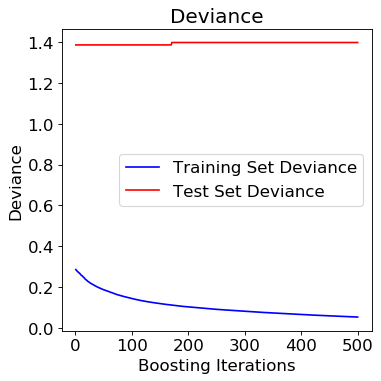

In [25]:
fig=plt.figure(figsize=(5, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.rcParams.update({'font.size': 15})

plt.title('Deviance')
plt.plot(np.arange(params['n_estimators']) + 1, clf.train_score_, 'b-',label='Training Set Deviance')
plt.plot(np.arange(params['n_estimators']) + 1, test_score, 'r-', label='Test Set Deviance')
plt.legend(loc='center right')
plt.xlabel('Boosting Iterations')
plt.ylabel('Deviance')

## Plot feature importance 

In [26]:
# Plot feature importance
feature_importance = clf.feature_importances_
feature_importance = 100.0 * (feature_importance / feature_importance.max())  # relative feature importance 
sorted_idx = np.argsort(feature_importance)

l = list(contestants_data_encoded)
contestant_features_ordered = [l[i] for i in sorted_idx]

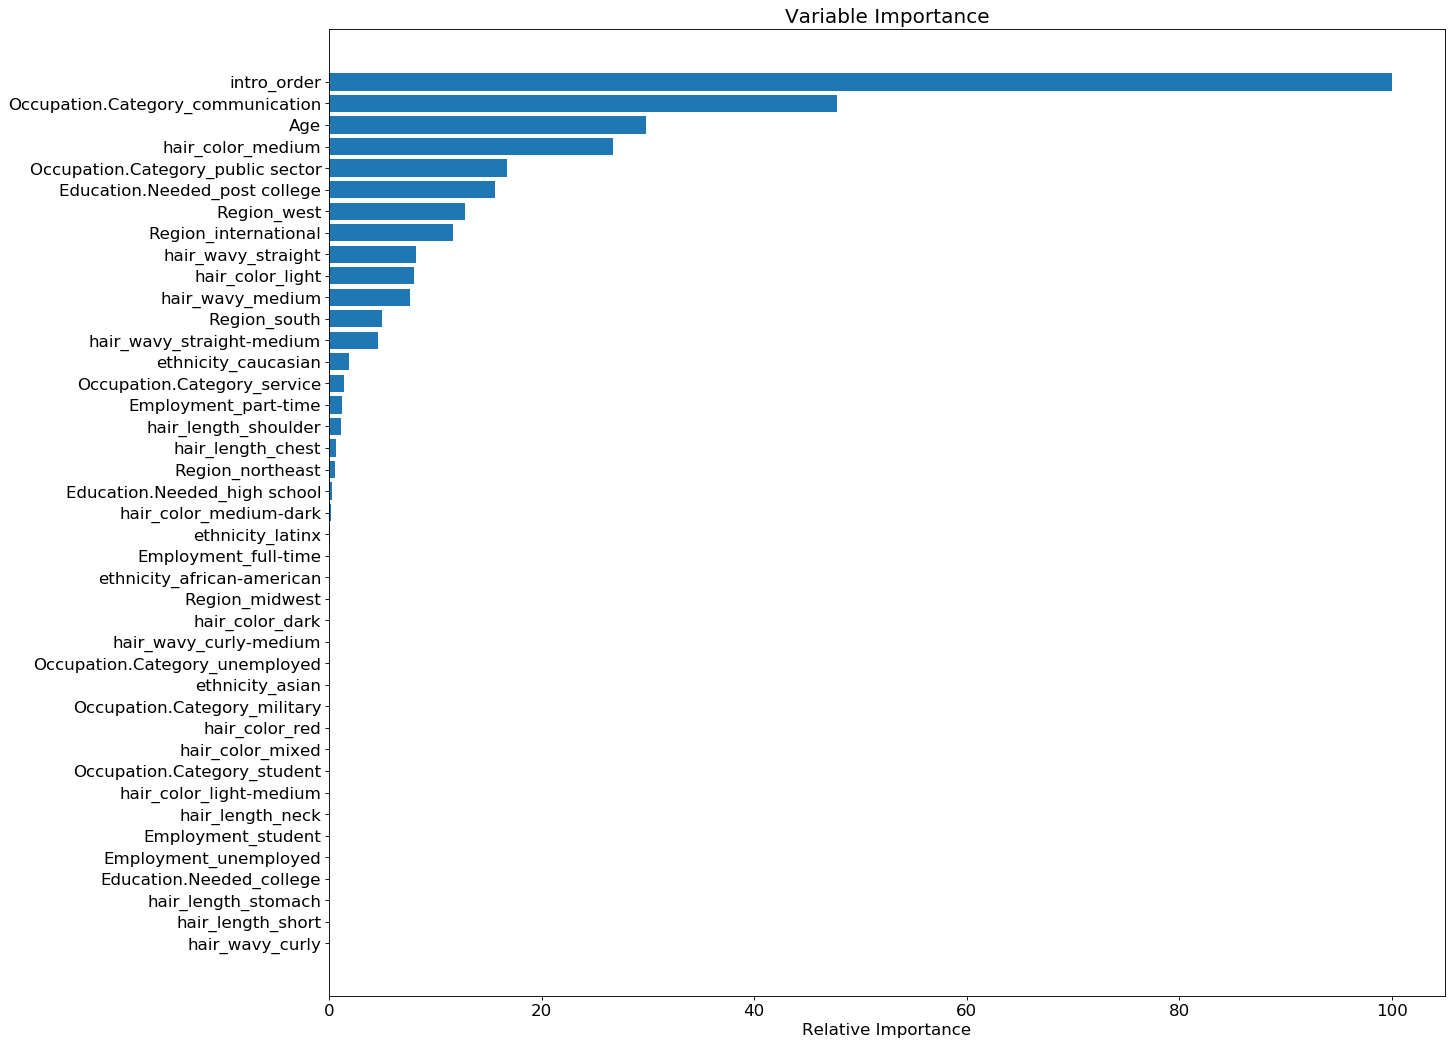

In [27]:
fig=plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')
plt.rcParams.update({'font.size': 15})

sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, contestant_features_ordered)
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()


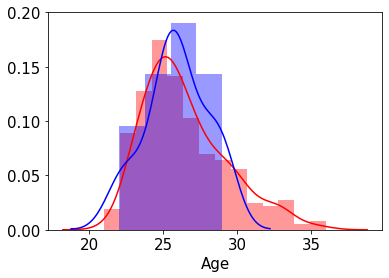

In [28]:
winners = contestants_df[contestants_df["Success"]==1]
losers = contestants_df[contestants_df["Success"]==0]

sns.distplot(losers["Age"], color="red")
sns.distplot(winners["Age"], color="blue")

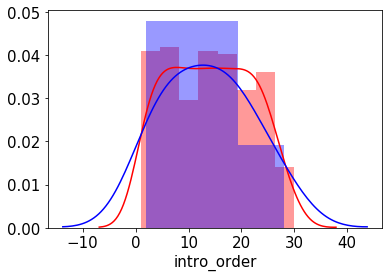

In [29]:
winners = contestants_df[contestants_df["Success"]==1]
losers = contestants_df[contestants_df["Success"]==0]

sns.distplot(losers["intro_order"], color="red")
sns.distplot(winners["intro_order"], color="blue")

## Continuous Prediction 

In [30]:
contestants_target = contestants_df["ElimWeek"].values`

In [32]:
X, y = shuffle(contestants_data, contestants_target, random_state=1)

offset = int(X.shape[0] * 0.7)  # set some amount of data as test and train 
X_train, y_train = X[:offset], y[:offset]
X_test, y_test = X[offset:], y[offset:]

print(len(y_train[y_train == 0])) # number of 'winning' contestants in train/test
print(len(y_test[y_test == 0]))

8
4


## Regression model 

In [51]:
params = {'n_estimators': 1500, 'max_depth': 2, 'min_samples_split': 4,
          'learning_rate': 0.01}

clf = ensemble.GradientBoostingRegressor(**params)

clf.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.01, loss='ls', max_depth=2,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=4,
                          min_weight_fraction_leaf=0.0, n_estimators=1500,
                          n_iter_no_change=None, presort='auto',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [52]:
print("y test", y_test) 
print("predicted", clf.predict(X_test).round(0))

y test [ 6.  6.  3.  1.  1.  1.  0.  2.  1.  4.  1.  9.  7.  7.  1.  3.  1.  2.
  5.  1.  1.  1.  8.  5.  1.  6.  6.  7.  2.  1.  3.  1.  1.  4.  3.  1.
  8.  8.  1.  3.  1.  1.  2.  1.  4.  1.  2.  9.  1.  7.  1.  1.  8.  1.
  3.  7.  1.  1.  1.  6.  1.  8.  1.  1.  0.  8.  1. 10.  4.  8.  1.  7.
  3.  4.  2.  1.  3.  9.  1.  5.  6.  7.  5.  0.  1.  1.  6.  1.  1.  6.
  4.  5.  2.  6.  4.  0.  7.  5.  1.  6.  6.  1.  1.  3.  1.]
predicted [ 3.  3.  3.  4.  3.  0.  4.  3.  4.  5.  3.  2.  3.  6.  2.  4.  4.  4.
  3.  2.  4.  3.  3.  4.  1.  3.  5.  5.  3.  4.  2.  3.  2.  3.  4.  3.
  6.  4.  2.  3. -0.  1.  8.  4.  5.  4.  4.  3.  4.  3.  4.  3.  3.  3.
  3.  5.  2.  2.  3.  5.  3.  5.  3.  1.  4.  3.  6.  4.  4.  4.  3.  5.
  5.  2.  5.  1.  4.  4.  1.  3.  3.  3.  2.  5.  2.  4.  4.  3.  3.  3.
  4.  3.  2.  1.  4.  3.  3.  5.  3.  5.  5.  3.  2.  2.  3.]


## MSE

In [53]:
mse = mean_squared_error(y_test, clf.predict(X_test))
print("MSE: %.4f" % mse)

MSE: 7.3413


## Accuracy

In [54]:
print("Accuracy score (training): {0:.4f}".format(clf.score(X_train, y_train)))
print("Accuracy score (test): {0:.4f}".format(clf.score(X_test, y_test)))

Accuracy score (training): 0.4228
Accuracy score (test): 0.0180


## Plot training deviance

In [55]:
# compute test set deviance
test_score = np.zeros((params['n_estimators'],), dtype=np.float64)

for i, y_pred in enumerate(clf.staged_predict(X_test)):
    test_score[i] = clf.loss_(y_test, y_pred)

Text(0, 0.5, 'Deviance')

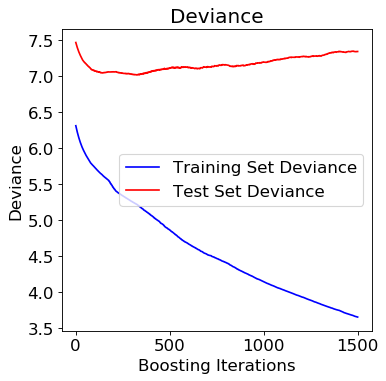

In [56]:
fig=plt.figure(figsize=(5, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.rcParams.update({'font.size': 15})

plt.title('Deviance')
plt.plot(np.arange(params['n_estimators']) + 1, clf.train_score_, 'b-',label='Training Set Deviance')
plt.plot(np.arange(params['n_estimators']) + 1, test_score, 'r-', label='Test Set Deviance')
plt.legend(loc='center right')
plt.xlabel('Boosting Iterations')
plt.ylabel('Deviance')

## Feature importance

In [43]:
# Plot feature importance
feature_importance = clf.feature_importances_
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)

l = list(contestants_data_encoded)
contestant_features_ordered = [l[i] for i in sorted_idx]

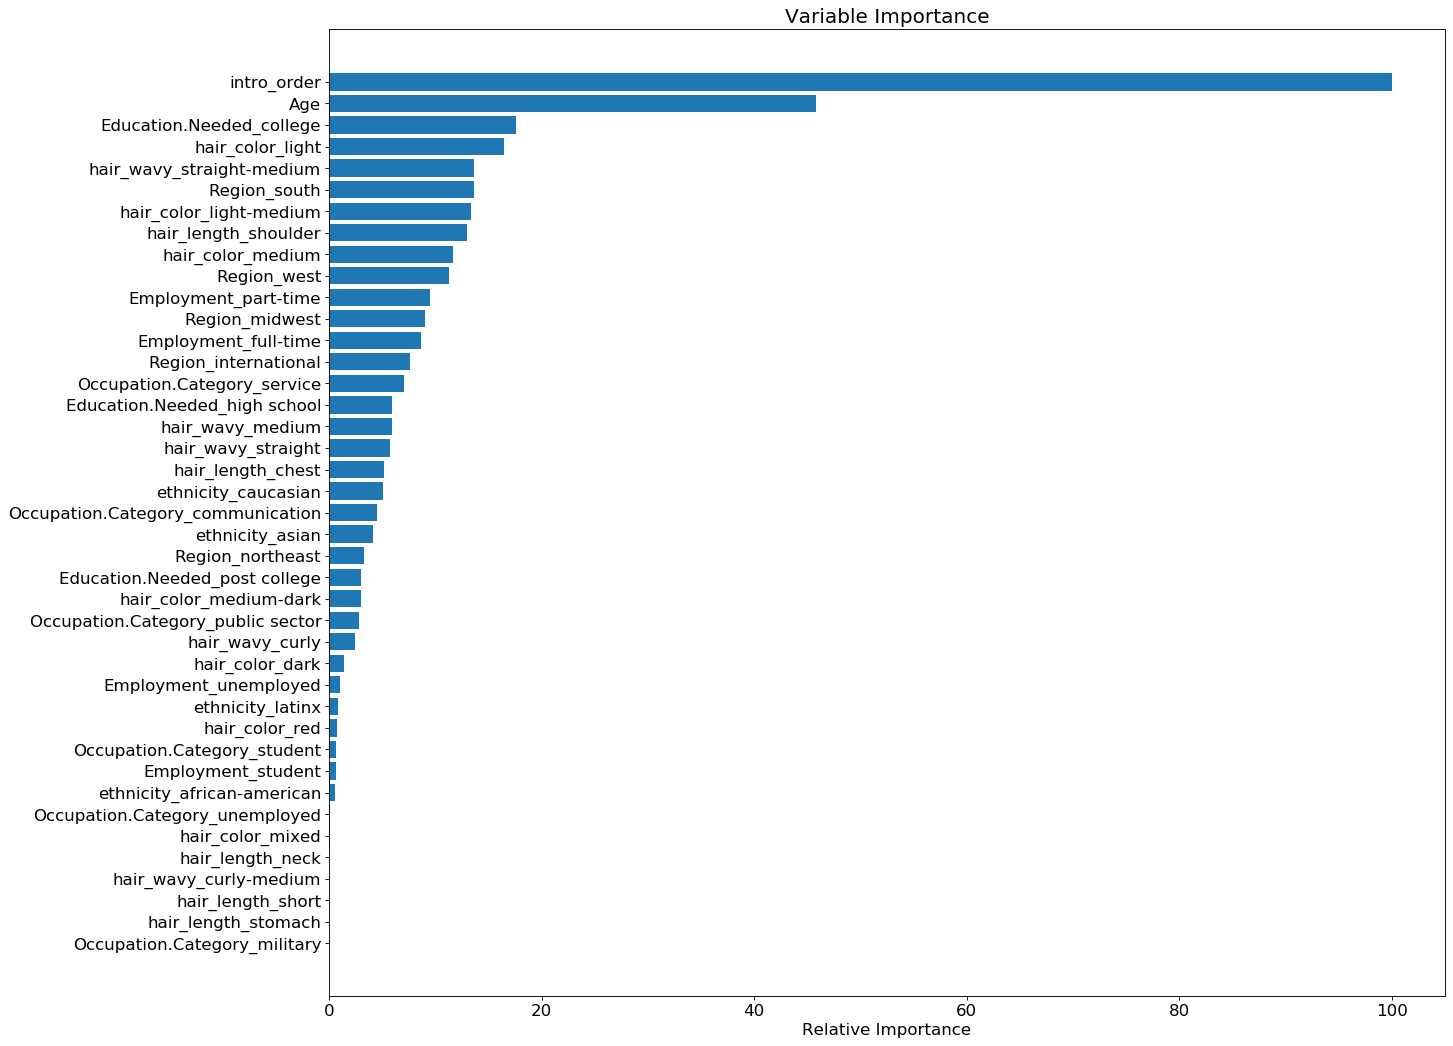

In [44]:
fig=plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')
plt.rcParams.update({'font.size': 15})

sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, contestant_features_ordered)
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()


## Intro Order Only 

In [ ]:
contestants_target = contestants_df["ElimWeek"].values
contestants_data = contestants_df["intro_order"].values

In [ ]:
X, y = shuffle(contestants_data, contestants_target, random_state=1)
X = X.reshape(-1, 1)

offset = int(X.shape[0] * 0.7)  # set some amount of data as test and train 
X_train, y_train = X[:offset], y[:offset]
X_test, y_test = X[offset:], y[offset:]

In [ ]:
params = {'n_estimators': 500, 'max_depth': 2, 'min_samples_split': 2,
          'learning_rate': 0.01}

clf = ensemble.GradientBoostingRegressor(**params)

clf.fit(X_train, y_train)

In [ ]:
print("y test", y_test) 
print("predicted", clf.predict(X_test).round(0))

## MSE

In [ ]:
mse = mean_squared_error(y_test, clf.predict(X_test))
print("MSE: %.4f" % mse)

## Accuracy

In [ ]:
print("Accuracy score (training): {0:.4f}".format(clf.score(X_train, y_train)))
print("Accuracy score (test): {0:.4f}".format(clf.score(X_test, y_test)))

## Deviance

In [ ]:
# compute test set deviance
test_score = np.zeros((params['n_estimators'],), dtype=np.float64)

for i, y_pred in enumerate(clf.staged_predict(X_test)):
    test_score[i] = clf.loss_(y_test, y_pred)

In [ ]:
fig=plt.figure(figsize=(5, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.rcParams.update({'font.size': 15})

plt.title('Deviance')
plt.plot(np.arange(params['n_estimators']) + 1, clf.train_score_, 'b-',label='Training Set Deviance')
plt.plot(np.arange(params['n_estimators']) + 1, test_score, 'r-', label='Test Set Deviance')
plt.legend(loc='center right')
plt.xlabel('Boosting Iterations')
plt.ylabel('Deviance')

## Logistic regression

### all features

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

In [ ]:
# make numpy array 
contestants_target = contestants_df["Success"].values
contestants_data = contestants_data_encoded.values

In [ ]:
X, y = shuffle(contestants_data, contestants_target, random_state=1)

offset = int(X.shape[0] * 0.7)  # set some amount of data as test and train 
X_train, y_train = X[:offset], y[:offset]
X_test, y_test = X[offset:], y[offset:]

In [ ]:
clf = LogisticRegression(random_state=0).fit(X_train, y_train)
predictions = clf.predict(X_test)
print("predictions:", predictions)
print("true y_test:", y_test)
print("Accuracy: {0:.4f}".format(accuracy_score(y_test, predictions)))

### intro order only 

In [ ]:
contestants_target = contestants_df["ElimWeek"].values
contestants_data = contestants_df["intro_order"].values

In [ ]:
X, y = shuffle(contestants_data, contestants_target, random_state=1)
X = X.reshape(-1, 1)
offset = int(X.shape[0] * 0.7)  # set some amount of data as test and train 
X_train, y_train = X[:offset], y[:offset]
X_test, y_test = X[offset:], y[offset:]

In [ ]:
clf = LogisticRegression(random_state=0).fit(X_train, y_train)
predictions = clf.predict(X_test)
print("predictions:", predictions)
print("true y_test:", y_test)
print("Accuracy: {0:.4f}".format(accuracy_score(y_test, predictions)))